In [ ]:
#!pip install xgboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score

##Adaboost

####Adaboost clasificacion

Construcción del dataframe:

In [ ]:
breast_cancer = load_breast_cancer()
cancer = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
cancer["diagnosis"] = pd.Categorical.from_codes(breast_cancer.target, breast_cancer.target_names)

In [ ]:
cancer.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  diagnosis  
0          0.4601                  0.11890  malignant  
1          0.2750                  0.08902  malignant  
2          0.3613                  0.08758  malignant  
3          0.6638                  0.17300  malignant  
4          0.2364                  0.07678  malignant  

[5 rows x 31 columns]

a) Realiza análisis de los valores faltantes:

In [ ]:
cancer.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
diagnosis                  0
dtype: int64

b) Determina si las clases están balanceadas:

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


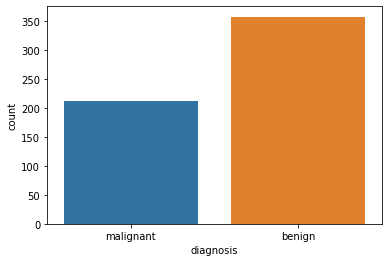

In [ ]:
cancer = cancer.dropna(axis=1)
#Get a count of the number of 'M' & 'B' cells
cancer["diagnosis"].value_counts()
#Visualize this count
sns.countplot(cancer["diagnosis"],label="Count")

c) Genera la matriz de correlaciones:

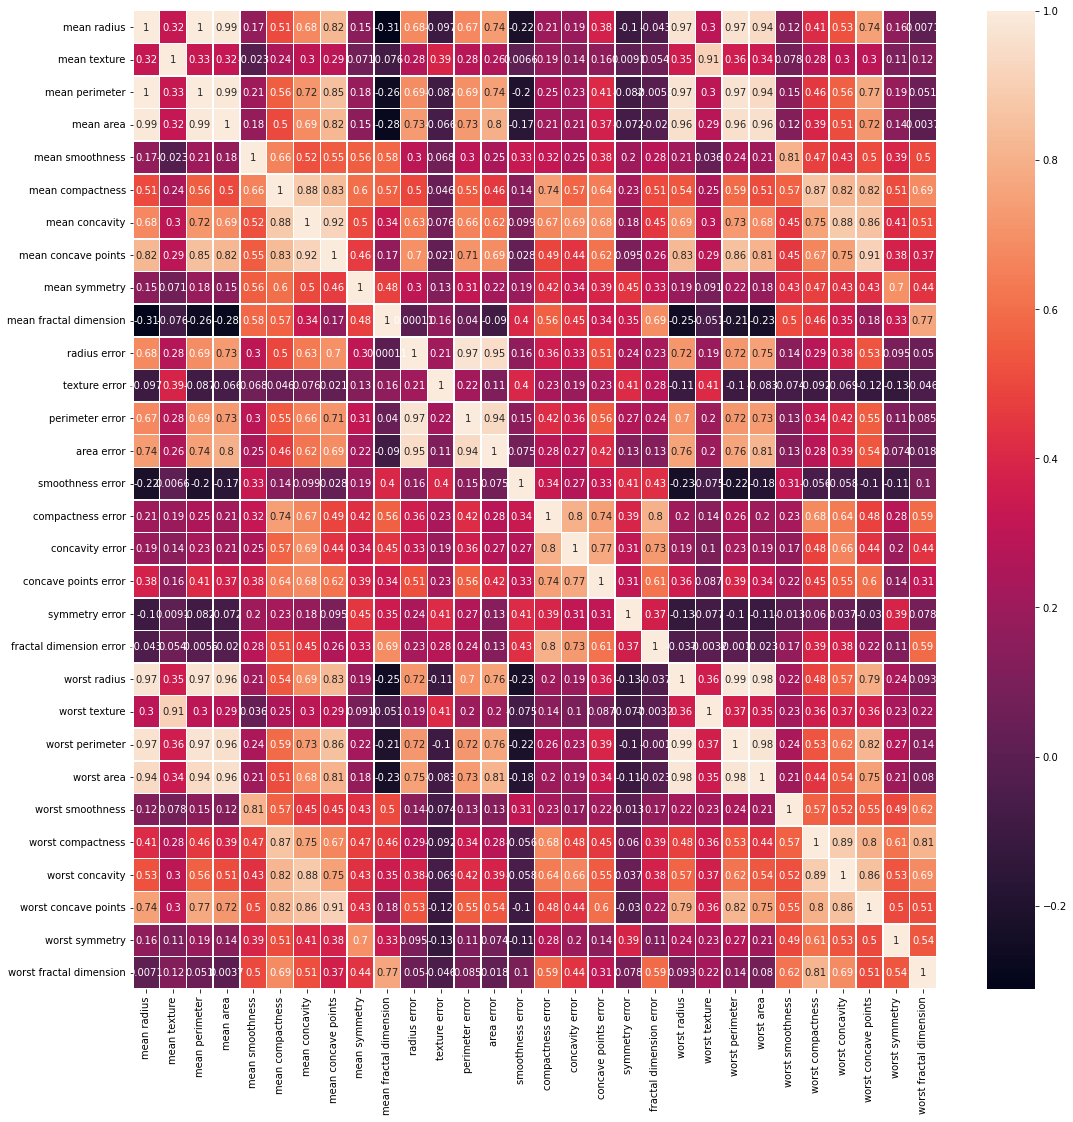

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(cancer.corr(), annot=True, linewidths=.5, ax = ax)

Text(0.5, 1.0, 'Graph of texture mean vs diagnosis of tumor')

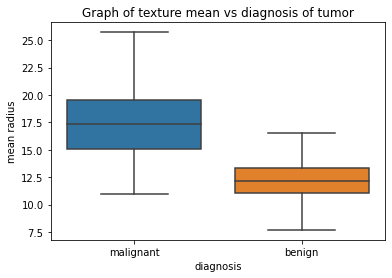

In [ ]:
plot = sns.boxplot(x='diagnosis', y='mean radius', data=cancer, showfliers=False)
plot.set_title("Graph of texture mean vs diagnosis of tumor")

**[EJERCICIO] Emplea un RandomForest para extraer la importancia de las variables en relación a la variable objetivo diagnosis**

In [ ]:
X = cancer.drop("diagnosis", axis = 1)
y = cancer["diagnosis"]

In [ ]:
rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 10)

In [ ]:
rf.fit(X,y)
rf.feature_importances_

array([0.00293871, 0.04351378, 0.00863122, 0.04884958, 0.00724043,
       0.01385923, 0.05101014, 0.16443955, 0.00486247, 0.01003525,
       0.00587402, 0.00277112, 0.01594022, 0.00916037, 0.00682799,
       0.00293877, 0.00741331, 0.00481215, 0.00693359, 0.0010209 ,
       0.22751094, 0.0215378 , 0.08280701, 0.14585583, 0.02530389,
       0.01982482, 0.00305067, 0.03086755, 0.01054275, 0.01362594])

Análisis de la importancia de variables:

<BarContainer object of 30 artists>

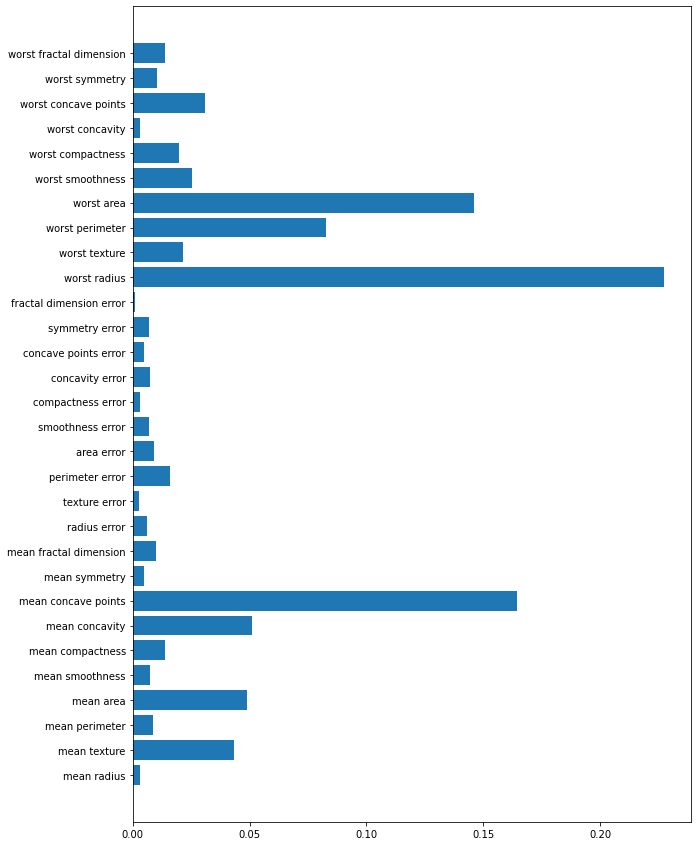

In [ ]:
plt.figure(figsize=(10,15))
plt.barh(X.columns, rf.feature_importances_)

Selección de las variables predictoras con mayor importancia:

In [ ]:
X = X[["worst concave points", "worst concavity",
       "worst radius", "mean concave points",
       "radius error", "mean perimeter", "mean radius"]]

Transformación de la variable target a dummy:

In [ ]:
dummies = pd.get_dummies(y)
y = dummies["malignant"]

División en entrenamiento y test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.3,
                                                    random_state = 123)

Estandarización de los datos:

In [ ]:
std = StandardScaler()
x_train_std = std.fit_transform(X_train)
x_test_std = std.transform(X_test)

Definición y entrenamiento del modelo:

In [ ]:
classifier = AdaBoostClassifier(n_estimators=200)
classifier.fit(x_train_std, y_train)

AdaBoostClassifier(n_estimators=200)

Predicción del modelo:

In [ ]:
pred_train = classifier.predict(x_train_std)
pred_test = classifier.predict(x_test_std)

Cálculo de las métricas en train:

In [ ]:
confusion_matrix(y_train, pred_train)

array([[254,   0],
       [  0, 144]])

In [ ]:
accuracy_score(y_train, pred_train)

1.0

In [ ]:
roc_auc_score(y_train, pred_train)

1.0

In [ ]:
fpr, tpr, threshold = roc_curve(y_train, pred_train)
roc_auc = roc_auc_score(y_train, pred_train)

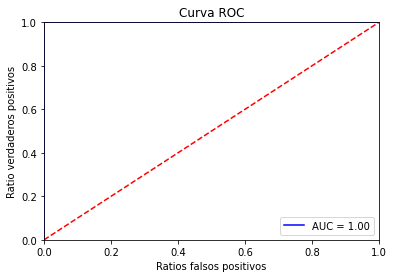

In [ ]:
plt.title('Curva ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

Cálculo de las métricas en test:

In [ ]:
confusion_matrix(y_test, pred_test)

array([[101,   2],
       [  6,  62]])

In [ ]:
accuracy_score(y_test, pred_test)

0.9532163742690059

In [ ]:
roc_auc_score(y_test, pred_test)

0.9461736150770987

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, pred_test)
roc_auc = roc_auc_score(y_test, pred_test)

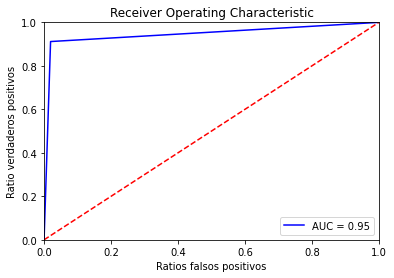

In [ ]:
plt.title('Curva ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

**[EJERCICIO] Visualización en un gráfico scatter 3D las variables predictoras a partir de hacer PCA previamente (sobre el conjunto de train). Asigna el color de cada muestra a la clase de la predicción:**

In [ ]:
pca = PCA()
train_pca = pca.fit_transform(x_train_std, y_train)

In [ ]:
#Varianza explicada:
varianza_explicada = pca.explained_variance_ratio_
cumsum_varianza_explicada = np.cumsum(varianza_explicada)

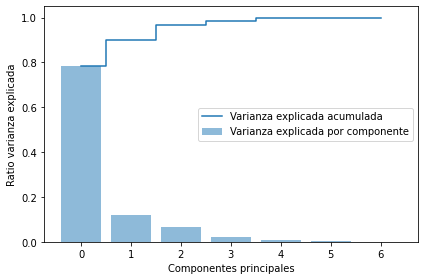

In [ ]:
plt.bar(range(0,len(varianza_explicada)),
        varianza_explicada, alpha=0.5,
        align='center',
        label='Varianza explicada por componente')
plt.step(range(0,len(cumsum_varianza_explicada)),
         cumsum_varianza_explicada, where='mid',
         label='Varianza explicada acumulada')
plt.ylabel('Ratio varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
varianza = pd.DataFrame(train_pca)[[0,1,2]]
varianza["label"] = y_train

In [ ]:
fig = px.scatter_3d(varianza, x=0, y=1, z=2,
              color='label')
fig.show()

####Adaboost regresion

**[EJERCICIO] Implementa el modelo Adaboost para predecir el precio (variable price) de las viviendas del dataset kc_house_data. Determina cuáles son las variables más relevantes (poder predictivo) a la hora de calcular la estimación del precio**

In [ ]:
house = pd.read_csv("kc_house_data.csv")

In [ ]:
house.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

¿Cuáles son las variables más relevantes (mayor poder predictivo)?

In [ ]:
correlation = house.iloc[:,2:].corr(method='pearson')
correlation.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

Correlación con la variable objetivo:

In [ ]:
correlation.price.sort_values(ascending=False)[1:]

sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
zipcode         -0.053203
Name: price, dtype: float64

Selección de variables mediante DecisionTreeClassifier:

In [ ]:
X = house.iloc[:,3:]
y = house["price"]

<BarContainer object of 18 artists>

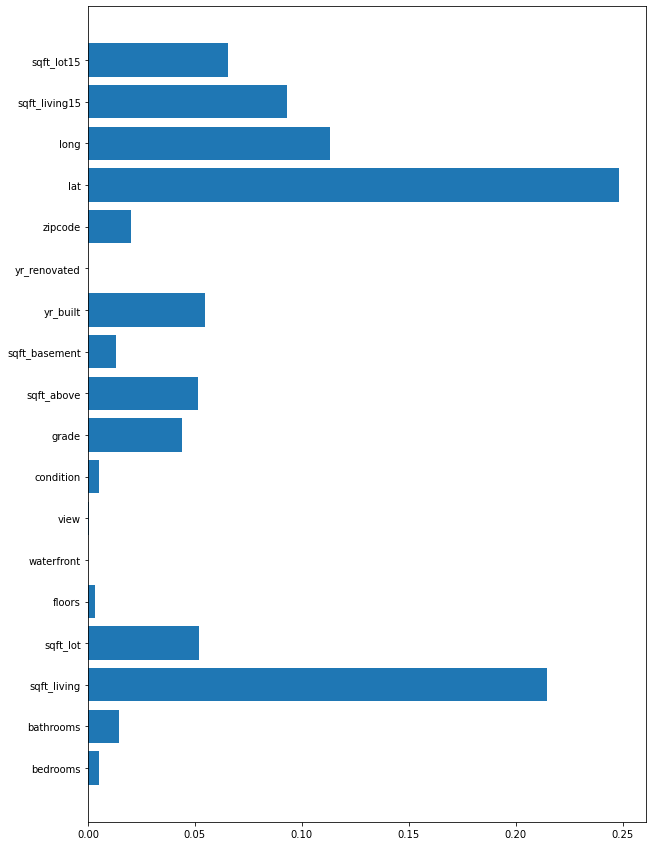

In [ ]:
dt = DecisionTreeClassifier(criterion = 'entropy',
                            max_depth = 10)
dt.fit(X,y)
dt.feature_importances_

plt.figure(figsize=(10,15))
plt.barh(X.columns, rf.feature_importances_)

División en entrenamiento y test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3)

Definición del modelo Adaboost:

In [ ]:
adaboost_regressor = AdaBoostRegressor(n_estimators=4)

In [ ]:
ada_model = adaboost_regressor.fit(X_train, y_train)

In [ ]:
prediction_test_ada = ada_model.predict(X_test)

Cálculo de las métricas:

##XGBoost

####XGBoost clasificacion

In [ ]:
diabetes = pd.read_csv("diabetes.csv")

In [ ]:
X = diabetes.drop("Outcome", axis = 1)
y = diabetes["Outcome"]

División train-test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Definición del modelo y entrenamiento:

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=8)

In [ ]:
xgb_model.fit(X_train, y_train)

XGBClassifier(max_depth=8)

In [ ]:
pred_train = xgb_model.predict(X_train)
pred_test = xgb_model.predict(X_test)

Cálculo de las métricas:

In [ ]:
#Train:
accuracy_score(pred_train, y_train)

1.0

In [ ]:
#Test:
accuracy_score(pred_test, y_test)

0.7597402597402597

**[EJERCICIO] Intenta mejorar el modelo implementando GridSearch. Utiliza cross validation (cv) = 5. Puedes consultar la documentación del GridSearch en:**

In [ ]:
params = {
 'max_depth':[4,5,6,8,10],
 'learning_rate': [0.01,0.001],
 'n_estimators':[50,100,150]
}

In [ ]:
gsearch = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid = params, cv = 5)

Entrenamiento del modelo con datos de train:

In [ ]:
gsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.01, 0.001],
                         'max_depth': [4, 5, 6, 8, 10],
                         'n_estimators': [50, 100, 150]})

¿Cuál es el mejor modelo?

In [ ]:
gsearch.best_estimator_

XGBClassifier(learning_rate=0.01, max_depth=4, n_estimators=150)

Predicción en train

In [ ]:
pred_train = gsearch.predict(X_train)

Predicción en test:

In [ ]:
pred_test = gsearch.predict(X_test)

Cálculo de métricas:

In [ ]:
#Train:
accuracy_score(pred_train, y_train)

0.8469055374592834

In [ ]:
#Test
accuracy_score(pred_test, y_test)

0.7727272727272727

**¿Qué conclusión puede sacarse?**

En el primer caso el modelo parece sobreajustado/sobreentrenado. Podemos visualizar la gráfica de acc:

In [ ]:
acc_train = []
acc_test = []
for i in range(1,12):
  xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=i, learning_rate = 0.01)
  xgb_model.fit(X_train, y_train)
  pred_train = xgb_model.predict(X_train)
  pred_test = xgb_model.predict(X_test)

  acc_train.append(accuracy_score(pred_train, y_train))
  acc_test.append(accuracy_score(pred_test, y_test))

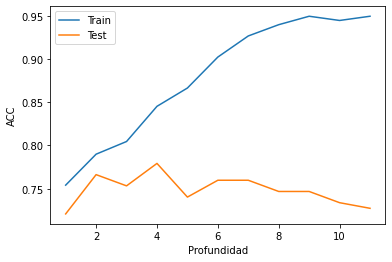

In [ ]:
plt.plot(range(1,12), acc_train, label = "Train")
plt.plot(range(1,12), acc_test, label = "Test")
plt.legend()
plt.xlabel("Profundidad")
plt.ylabel("ACC")
plt.show()

####XGBoost regresion

In [ ]:
house = house.iloc[:,2:]
house.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      7        2170            400      1951          1991   
2     0          3      6         770              0      1933             0   
3     0          5      7        1050            910      1965             0   
4     0          3      8        1680              0      1987             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98125  47.7210 -122.319           1690        7639  
2    98028  47.7379 -122.233           2720        8062  
3    98136  47.5208 -122.393           1360        5000  
4    98074  47.6168 -122.045           1800        7503

In [ ]:
X = house.drop("price", axis = 1)
y = house["price"]

División en entrenamiento y test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Definición del modelo:

In [ ]:
xgb_reg = xgb.XGBRegressor()

Implementación cross validation (dividiendo el conjunto de train en 10 subconjuntos y repitiendo el proceso 3 veces)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

La métrica seleccionada es mean_absolute_error:

In [ ]:
scores = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv);

Error absoluto:

In [ ]:
score_abs = np.absolute(scores)

Distribución de los errores

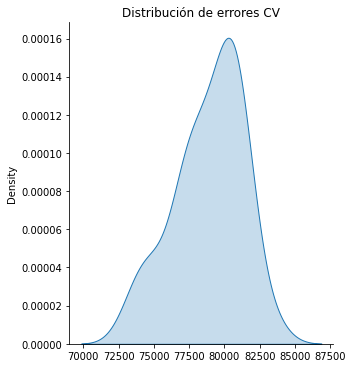

In [ ]:
sns.displot(score_abs, kind="kde", fill = True);
plt.title("Distribución de errores CV");


In [ ]:

print(f"MAE {score_abs.mean()}, std: {scores.std()}")

MAE 78871.10151791738, std: 2365.3319973254434


**[EJERCICIO] Varía los hiperparámetros del modelo para reducir el error:**